In [2]:
#import
import pandas as pd
import numpy as np
import os
import json
from IPython.core.display import display
%matplotlib inline
import tweepy
import networkx as nx
import random
from pyvis.network import Network
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms.approximation import clique
from scipy import stats
data_folder = "data"
print("imported completed!")

imported completed!


In [3]:
#Twitter API credentials
consumer_key = ""
consumer_secret = ""
access_token = ""
access_secret = ""
bearer_token = ""

In [4]:
#authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
if api.verify_credentials :
  print ('Authentication completed successfully!')

Authentication completed successfully!


In [5]:
#definisco le due funzioni per salvare e leggere file json
def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}", "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
    print(f"Data serialized to path: {folder}/{filename}")
def read_json(path):
    if os.path.exists(path):
        with open(path, "r", encoding="utf8") as file:
            data = json.load(file)
        print(f"Data read fron path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

In [6]:
#definisco gli utenti
#prendo per ogni utente della consegna il suo ID con questa funzione
def fromUsernamesToId(users):
    usersID = []
    for user in users:
        json_data = api.get_user(user)._json
        usersID.append(json_data["id"])
    return usersID

users = ["mizzaro","damiano10","Miccighel_","eglu81","KevinRoitero"]
usersId = fromUsernamesToId(users)

In [23]:
#utilizzando gli id trovati precedentemente,
#con questa funzione scarico tutti gli id dei followers di un account
def download_followers(idUser):
    followers_of_user = []
    for follower in tweepy.Cursor(
            api.followers,
            id=idUser,
            skip_status=True,
            include_user_entities=False
    ).items():
        followers_of_user.append(follower._json["id"])
    return followers_of_user

index = 0
#creo un file con gli utenti scaricati per ogni account
for idUser in usersId:
    followers = download_followers(idUser)
    serialize_json(data_folder,f"followers_{users[index]}.json", followers)
    index += 1

Data serialized to path: data/followers_tomve99.json
Data serialized to path: data/followers_lucabazzetto.json


In [58]:
#scarico tutti gli id dei friends per ogni account
def download_friends(idUser):
    friends_of_user = []
    for friend in tweepy.Cursor(
            api.friends,
            id=idUser,
            skip_status=True,
            include_user_entities=False
    ).items(quantity):
        friends_of_user.append(friend._json["id"])
    return friends_of_user

index = 0
for idUser in usersId:
    friends = download_friends(idUser)
    serialize_json(data_folder,f"friends_{users[index]}.json", friends)
    index +=1

Data serialized to path: data/friendsLucaThomas.json


In [ ]:
#aggiungo utente solo se non è presente tra quelli già trovati
def randomUsersFromList(listOfUsers, quantity):
    usersToFind = quantity
    array = []
    while (usersToFind != 0):
        item = random.choice(listOfUsers)
        if item not in array:
            array.append(item)
            usersToFind -= 1
    return array

In [10]:
#per ogni utente trovo i 5 utenti random
#poi per quelli trovati scarico i 10 followers
files = [
    f"{data_folder}/followers_damiano10.json",
    f"{data_folder}/followers_eglu81.json",
    f"{data_folder}/followers_Miccighel_.json",
    f"{data_folder}/followers_mizzaro.json",
    f"{data_folder}/followers_KevinRoitero.json"
]
# Estraggo per ogni utente 5 followers
randomUsers = 5
quantity = 10
followersOfFollowers = []
for file in files:
    followers = read_json(file)
    usersFound = randomUsersFromList(followers, randomUsers)
    for user in usersFound:
        followersOfFollowers[user]= download_followers(user)

serialize_json(data_folder,"followersOfFollowers.json", followersOfFollowers)

Data read fron path: data/followers_damiano10.json
Data read fron path: data/followers_eglu81.json
Data read fron path: data/followers_Miccighel_.json
Data read fron path: data/followers_mizzaro.json
Data read fron path: data/followers_KevinRoitero.json
Data serialized to path: data/followersOfFollowers.json


Rate limit reached. Sleeping for: 860
Rate limit reached. Sleeping for: 894


In [62]:
#per ogni utente trovo i 5 utenti random
#poi per quelli trovati scarico i 10 friends
files = [
    f"{data_folder}/friends_damiano10.json",
    f"{data_folder}/friends_eglu81.json",
    f"{data_folder}/friends_Miccighel_.json",
    f"{data_folder}/friends_mizzaro.json",
    f"{data_folder}/friends_KevinRoitero.json"
]
# Estraggo per ogni utente 5 friends
randomUsers = 5
quantity = 10
friendsOfFriends = []
for file in files:
    friends = read_json(file)
    usersFound = randomUsersFromList(friends, randomUsers)
    for user in usersFound:
        friendsOfFriends[user] = download_friends(user)

serialize_json(data_folder,"friendsOfFriends.json", friendsOfFriends)

Data read fron path: data/friendsLucaThomas.json
Data serialized to path: data/friendsOfFriends.json


In [ ]:
#riunisco i file e metto tutti gli id in un'unica lista
def mergeFiles(file_names):
    allItems = []
    for file in file_names:
        jsonData = read_json(file)
        for (key, value) in jsonData.items():
            for item in value:
                allItems.append(item)
    return allItems

#elimino tutti i duplicati data una lista
def deleteDuplicates(allItems):
    vector = []
    for item in allItems:
        if item not in vector:
            vector.append(item)
    return vector

In [6]:
#tutti i file dove eliminare i duplicati
file_names = [
    f"{data_folder}/followersOfFollowers.json",
    f"{data_folder}/friendsOfFriends.json",

    f"{data_folder}/followers_damiano10.json",
    f"{data_folder}/followers_eglu81.json",
    f"{data_folder}/followers_KevinRoitero.json",
    f"{data_folder}/followers_Miccighel_.json",
    f"{data_folder}/followers_mizzaro.json",

    f"{data_folder}/friends_damiano10.json",
    f"{data_folder}/friends_eglu81.json",
    f"{data_folder}/friends_KevinRoitero.json",
    f"{data_folder}/friends_Miccighel_.json",
    f"{data_folder}/friends_mizzaro.json"
]

#creo vettore con tutti gli id degli utenti senza duplicazione
noDuplicates =  deleteDuplicates(mergeFiles(file_names))

serialize_json(data_folder,"noDuplicati.json", noDuplicates)

Data read fron path: data/followersOfFollowers.json
Data read fron path: data/friendsOfFriends.json
Data read fron path: data/followers_damiano10.json
Data read fron path: data/followers_eglu81.json
Data read fron path: data/followers_KevinRoitero.json
Data read fron path: data/followers_Miccighel_.json
Data read fron path: data/followers_mizzaro.json
Data read fron path: data/friends_damiano10.json
Data read fron path: data/friends_eglu81.json
Data read fron path: data/friends_KevinRoitero.json
Data read fron path: data/friends_Miccighel_.json
Data read fron path: data/friends_mizzaro.json
Data serialized to path: data/noDuplicati.json


In [ ]:
#punto 4
noDuplicates = read_json(f"{data_folder}/noDuplicati.json")
index = 0
usersDetails = {}
#dato un id utente, ritorno tutte le sue informazioni
def downloadUserDetails(userId):
    try:
        json_data = api.get_user(userId)._json
        foundInfo = {
            'id': json_data['id'],
            'name': json_data['name'],
            'screen_name': json_data['screen_name'],
            'location': json_data['location'],
            'followers_count': json_data['followers_count'],
            'friends_count': json_data['friends_count']
        }
        return foundInfo
    except tweepy.error.TweepError:
        print(userId)

#scarico tutte le informazioni di tutti gli utenti senza duplicazioni
for userId in noDuplicates:
    usersDetails[index] = downloadUserDetails(userId)
    index = index + 1

df = pd.DataFrame.from_dict(usersDetails,orient='index')
display(df)
df.to_csv("usersDetails.csv", index=False, encoding='utf-8')

In [ ]:
#ritorna il tipo di relazione che c'è dati due id utente
#Both: relazione di follows tra entrambi gli utenti
#SourceToTarget: source id segue il target id
#TargetToSource: source id è seguito dal target id
def friendship(sourceid, targetid):
    try:
        friendship = api.show_friendship(source_id=sourceid, target_id=targetid)
        if friendship[0].following & friendship[0].followed_by:
            return "Both"
        else:
            if friendship[0].following:
                return "SourceToTarget"
            if friendship[0].followed_by:
                return "TargetToSource"
            return None
    except tweepy.error.TweepError:
        print("errore")
        print(targetid)
        return None

#trovo gli id dei 5 utenti
usersId = fromUsernamesToId(users)
noDuplicates = read_json(f"{data_folder}/noDuplicati.json")
index = 0
sourceTarget =[]
#per ogni utente dei 5 account, trovo quale relazione ha con tutti gli utenti
for source in usersId:
    for target in noDuplicates:
        relation = friendship(source,target)
        if relation:
            foundFriendship = {
                "source": source,
                "target": target,
                "friendship": relation
            }
            sourceTarget.append(foundFriendship)

df = pd.DataFrame(sourceTarget)
display(df)
df.to_csv("sourceTarget.csv",index = False , encoding='utf-8')

In [ ]:
#prima di creare i nodi cerco tutti gli utenti che hanno una relazione
relazioni = pd.read_csv("sourceTarget.csv")
listTarget = list(relazioni['target'])
totale = deleteDuplicates(listTarget)
#nella variabile totale sono presenti tutti i futuri nodi da creare

#elimino le righe in più, quelle con le persone che non sono da inserire nel grafo perchÃ¨ non hanno relazioni
userDetailsOld = pd.read_csv("usersDetails.csv")

indexToDelete = []
for index,row in userDetailsOld.iterrows():
    if row['id'] not in totale:
        indexToDelete.append(index)

#cancello tutte le righe
userDetails = userDetailsOld.drop(userDetailsOld.index[indexToDelete])
df.to_csv("usersDetailsForGraph.csv",index = False , encoding='utf-8')

In [35]:
#grafo orientato
dfUsersDetails = pd.read_csv("usersDetailsForGraph.csv")
dfUsersFriendship = pd.read_csv("sourceTarget.csv")

graph = nx.DiGraph()

#aggiunta membri gruppo come attributi
graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for index,row in dfUsersDetails.iterrows():
    graph.add_node(row['id'], label =row['screen_name'],name = row['name'],location = row['location'],followers_count = row['followers_count'],friends_count = row['friends_count'])

for index, row in dfUsersFriendship.iterrows():
    if row["friendship"] == "SourceToTarget":
        graph.add_edge(row["source"], row["target"])
    elif row["friendship"] == "TargetToSource" :
        graph.add_edge(row["target"], row["source"])
    else :
        graph.add_edge(row["source"], row["target"])
        graph.add_edge(row["target"], row["source"])

nx.write_gpickle(graph,"data/orientedGraph.pkl")

In [5]:
#grafo non orientato
dfUsersDetails = pd.read_csv("usersDetailsForGraph.csv")
dfUsersFriendship = pd.read_csv("sourceTarget.csv")

graph = nx.Graph()

#aggiunta membri gruppo come attributi
graph.graph["members"] = ["Luca","Thomas","Agustin","Edoardo"]

for index,row in dfUsersDetails.iterrows():
    graph.add_node(row['id'], label = row['screen_name'],name = row['name'],location = row['location'],followers_count = row['followers_count'],friends_count = row['friends_count'])

for index, row in dfUsersFriendship.iterrows():
    graph.add_edge(row["source"], row["target"],weight = 1,id = index)

nx.write_gpickle(graph,"data/unOrientedGraph.pkl")

,id,name,screen_name,location,followers_count,friends_count
0,989428140433866752,Innovation Center for Artificial Intelligence,ic4ai,"Amsterdam, The Netherlands",1079,15
1,984275749824638976,ielab,IELabGroup,"Brisbane, Queensland",75,66
2,3235806942,Justin Zobel,j_zob,"Melbourne, Victoria",86,13
3,862356144748204032,DESIRES2020,DESIRES_IR,"Venezia, Veneto",269,111
4,610026759,Rocío Cañamares,rcanamares,NaN,101,98
...,...,...,...,...,...,...
2705,48062712,Luigi Di Maio,luigidimaio,"Pomigliano d'Arco, Campania",698293,386
2706,54163837,Philipp Mayr,Philipp_Mayr,"Colonia, Germania",1024,328
2707,911297187664949248,Jeff Dean (@🏡),JeffDean,NaN,175712,4274
2708,2575124365,Daniel Garijo,dgarijov,NaN,526,245


,source,target,friendship
0,19659370,18932422,Both
1,19659370,132646210,Both
2,19659370,15750573,TargetToSource
3,19659370,1425336134,TargetToSource
4,19659370,918943909811769344,TargetToSource
...,...,...,...
3309,15750573,131526573,SourceToTarget
3310,15750573,13533662,SourceToTarget
3311,15750573,52352322,SourceToTarget
3312,15750573,58324434,SourceToTarget


In [17]:
#punto 6
#grafo interattivo 
graph = nx.read_gpickle("data/unOrientedGraph.pkl")

nt = Network(
    height="100%",
    width="100%",
    bgcolor="255255255",
    font_color="black",
    heading="progetto"
)
nt.barnes_hut()
nt.from_nx(graph)
neighbor_map = nt.get_adj_list()
for node in nt.nodes:
    node["Value"] = len(neighbor_map[node['id']])
nt.show("grafico.html")

Grafo connesso
Centro:  [19659370, 132646210, 3036907250]
Diametro:  4
Raggio:  2
Grafo non bipartito


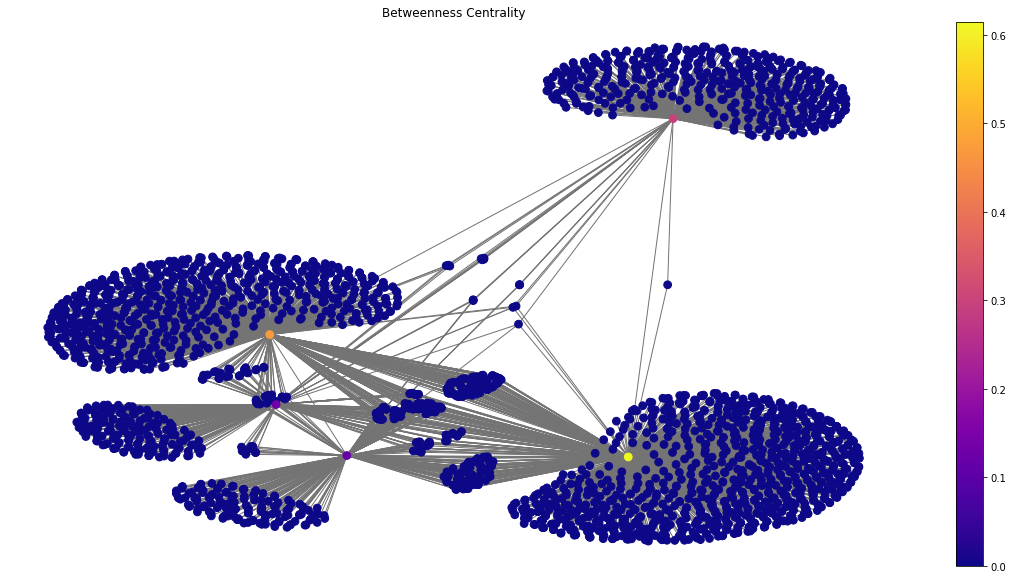

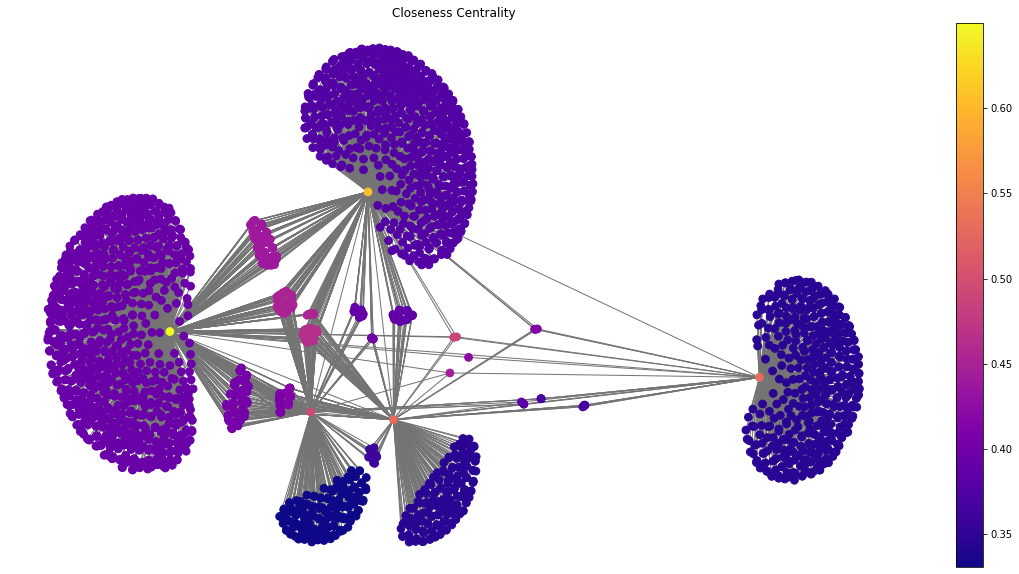

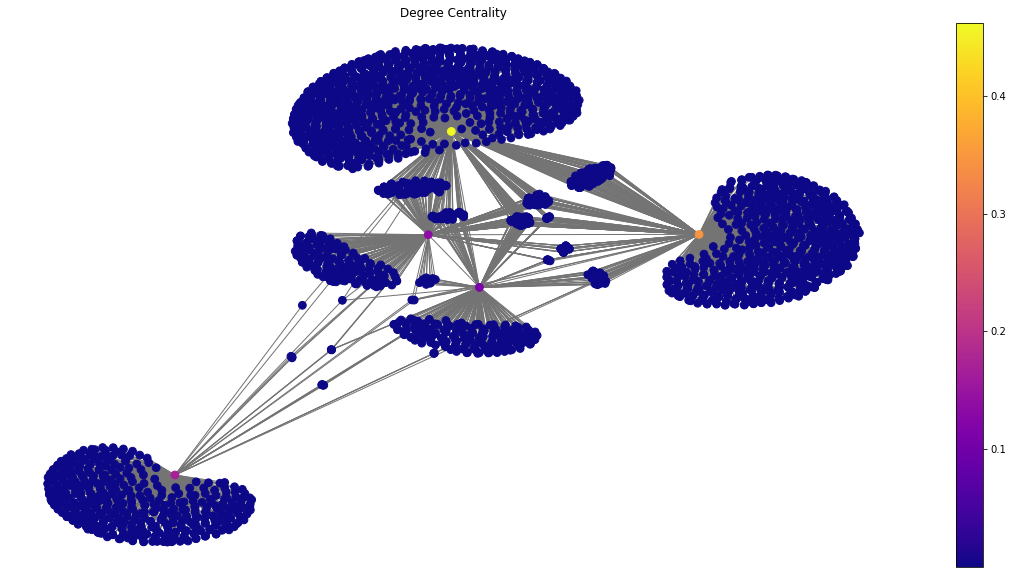

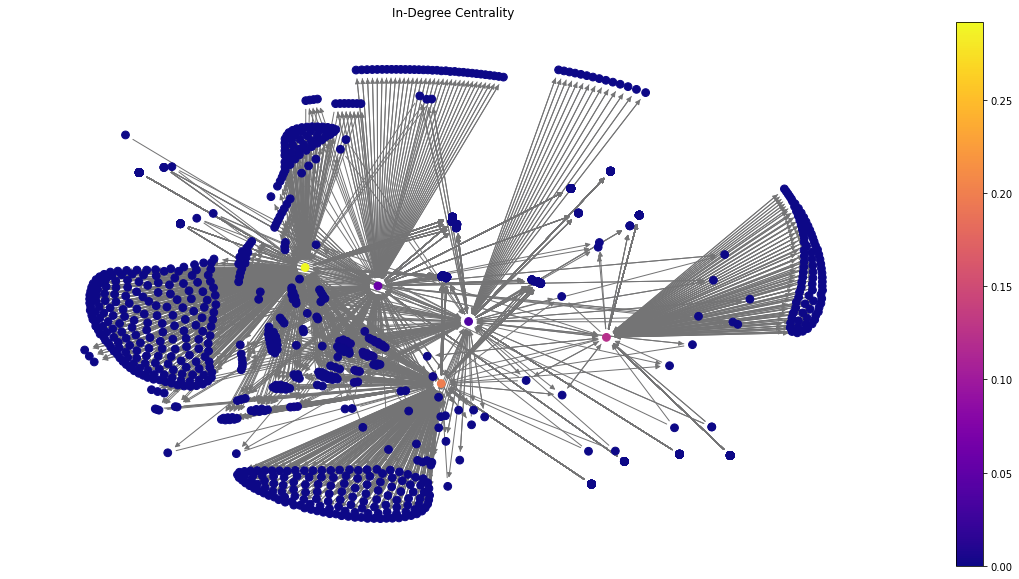

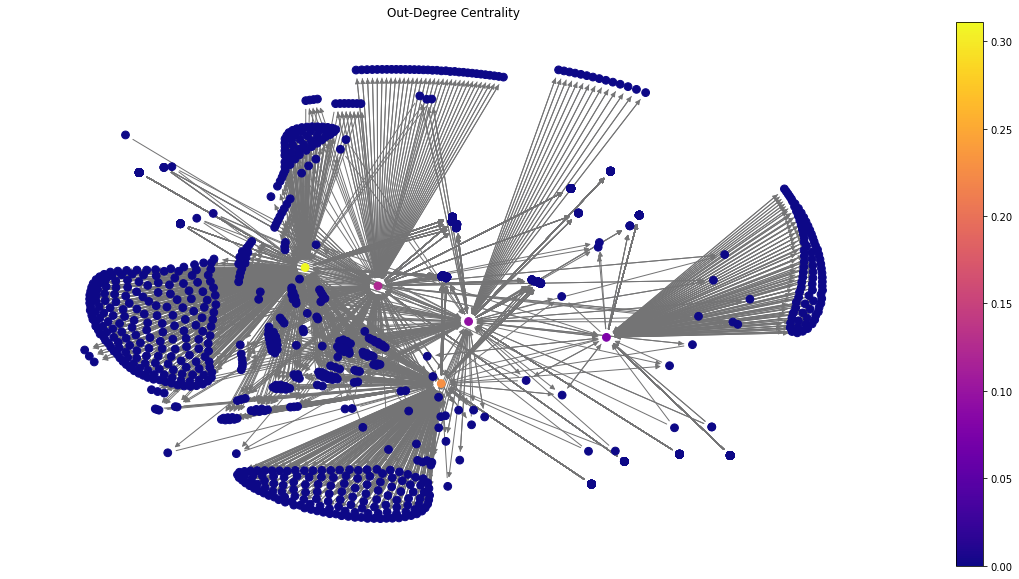

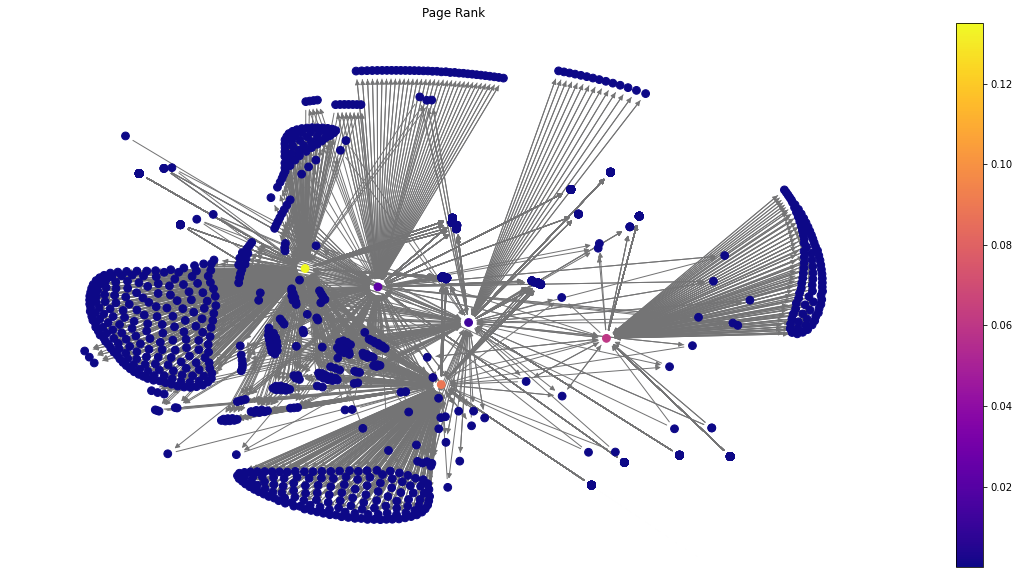

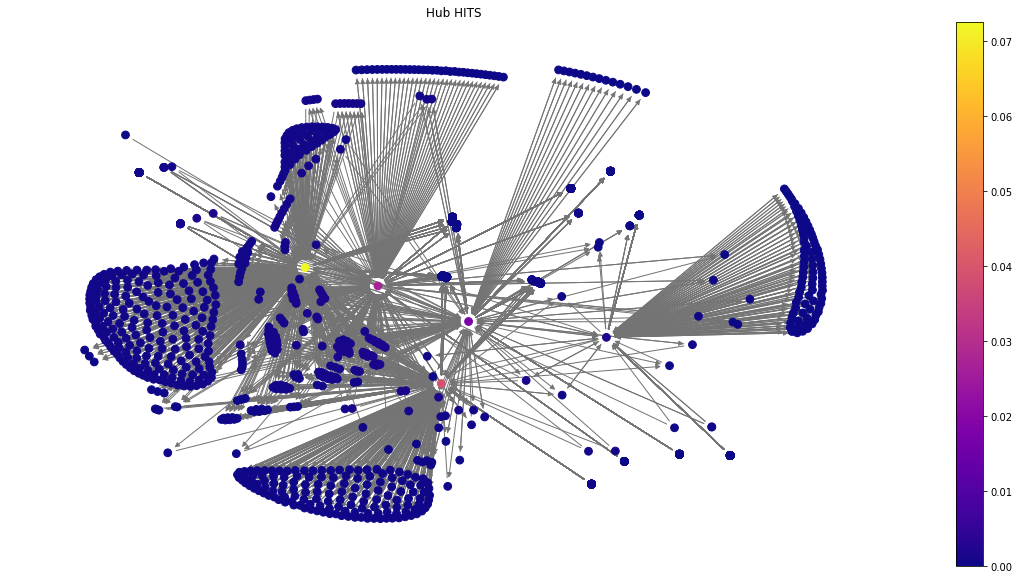

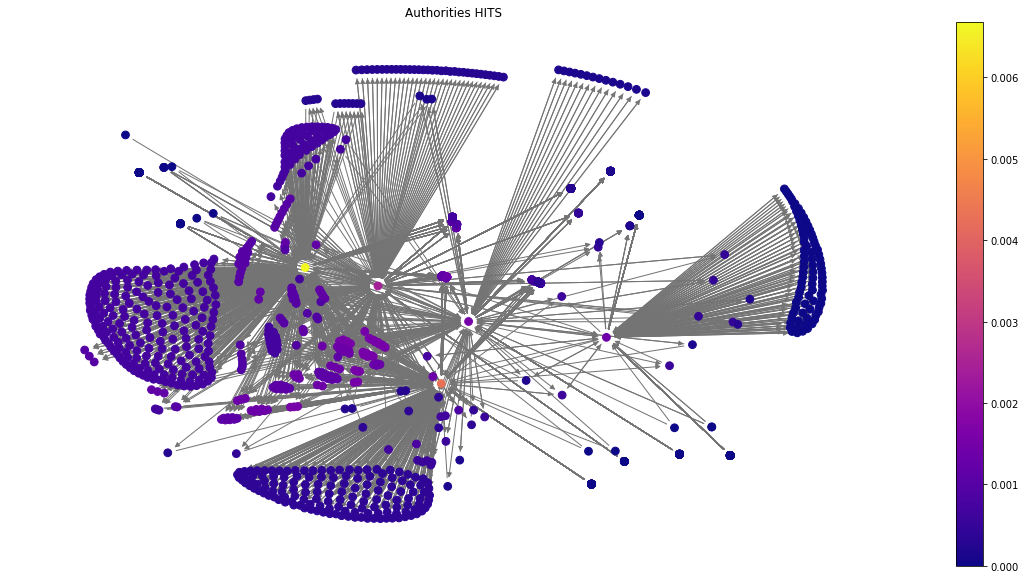

Data serialized to path: data/Betweenness.json
Data serialized to path: data/Closeness.json
Data serialized to path: data/Degree.json
Data serialized to path: data/In_degree.json
Data serialized to path: data/Out_degree.json
Data serialized to path: data/Pagerank.json
Data serialized to path: data/Hub.json
Data serialized to path: data/Authorities.json


In [24]:
#Punto 7/8/9
from networkx.algorithms.distance_measures import center

#funzione per il disegno della funzione in base alle misure di centralità del grafo
def draw(G, pos, measures, measure_name):
    plt.figure(figsize=(20,10)) 
    nodes = nx.draw_networkx_nodes(G,
                                   pos, 
                                   node_size=60, 
                                   cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys()
                                  )
    edges = nx.draw_networkx_edges(G,pos, edge_color = "#747475")
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis("off")
    plt.show()

unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")
oriented = nx.read_gpickle("data/orientedGraph.pkl")

#Se il grafo è connesso, posso calcolare anche il centro, il diametro e il raggio
if(nx.is_connected(unOriented)):
    print("Grafo connesso"),
    print("Centro: ", end=" ")
    print(nx.center(unOriented))
    print("Diametro: ", end=" ")
    print(nx.diameter(unOriented))
    print("Raggio: ", end=" ")
    print(nx.radius(unOriented))

else:
    print("Grafo non connesso")

#Verifica se il grafo è bipartito
if(nx.is_bipartite(unOriented)):
    print("Grafo bipartito")
else:
    print("Grafo non bipartito")



#Calcolo delle misure di centralità sul grafo
bet = nx.betweenness_centrality(unOriented)
close = nx.closeness_centrality(unOriented)
degree = nx.degree_centrality(unOriented)
ind = nx.in_degree_centrality(oriented)
outd = nx.out_degree_centrality(oriented)
pr = nx.pagerank(oriented)
hub, authorities = nx.hits(oriented, max_iter=600)


#Disegno del grafo con le misure di centralità
draw(
    unOriented,
    nx.spring_layout(unOriented),
    bet,
    "Betweenness Centrality"
)
draw(
    unOriented,
    nx.spring_layout(unOriented),
    close,
    "Closeness Centrality"
)
draw(
    unOriented,
    nx.spring_layout(unOriented),
    degree,
    "Degree Centrality"
)

draw(
    oriented,
    nx.kamada_kawai_layout(oriented),
    ind,
    "In-Degree Centrality"
)
draw(
    oriented,
    nx.kamada_kawai_layout(oriented),
    outd,
    "Out-Degree Centrality"
)
draw(
    oriented,
    nx.kamada_kawai_layout(oriented),
    pr,
    "Page Rank"
)
draw(
    oriented,
    nx.kamada_kawai_layout(oriented),
    hub,
    "Hub HITS"
)
draw(
    oriented,
    nx.kamada_kawai_layout(oriented),
    authorities,
    "Authorities HITS"
)

#Salvataggio delle misure di centralità in un file .json
serialize_json(data_folder,"Betweenness.json", bet)
serialize_json(data_folder,"Closeness.json", close)
serialize_json(data_folder,"Degree.json", degree)
serialize_json(data_folder,"In_degree.json", ind)
serialize_json(data_folder,"Out_degree.json", outd)
serialize_json(data_folder,"Pagerank.json", pr)
serialize_json(data_folder,"Hub.json", hub)
serialize_json(data_folder,"Authorities.json", authorities)

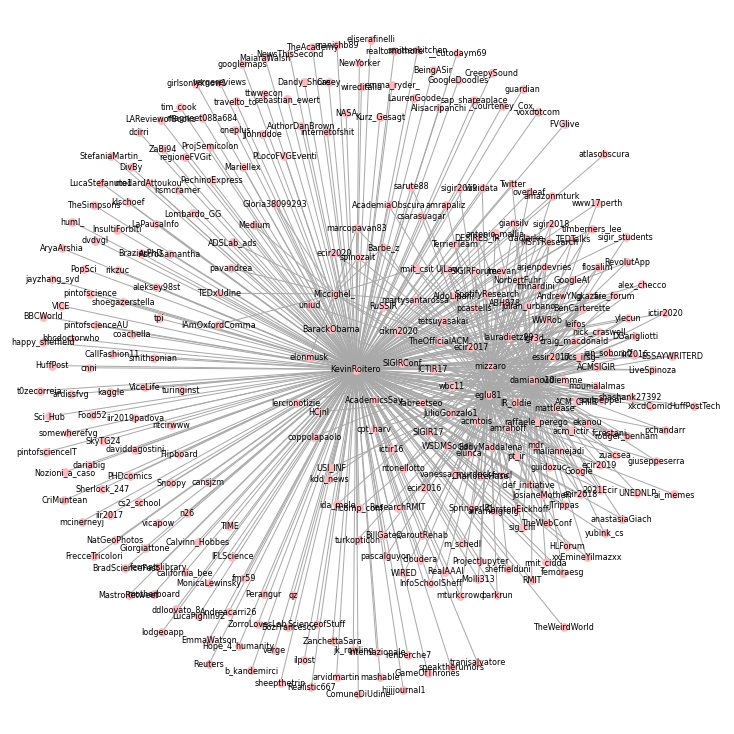

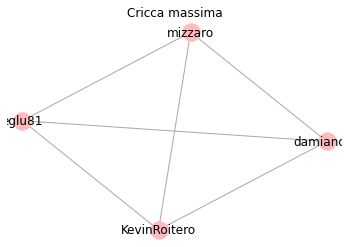

In [70]:
#Punto 10
unOriented = nx.read_gpickle("data/UnOrientedGraph.pkl")

#Generazione del sottografo di "KevinRoitero"
subgraph = nx.ego_graph(unOriented, userID("KevinRoitero",api), radius=1)


#Calcolo della cricca massima
print("Cricca massima: ", end=" ")
max_cl = clique.max_clique(subgraph)
print(max_cl)
print(" ")

#Calcolo della dimensione cricca massima
print("Dimensione della cricca massima: ", end=" ")
print(clique.large_clique_size(subgraph))
print(" ")

#Disegno del sottografo generato
plt.figure(figsize=(10,10)) 
nx.draw(
    subgraph,
    labels = nx.get_node_attributes(subgraph, 'label'),
    pos = nx.spring_layout(subgraph),
    node_color = "#febabc",
    edge_color = "#A9A9A9",
    edge_cmap = plt.cm.Blues,
    node_size=60,
    font_size=8,
)

plt.savefig("data/subgraph.pdf")
plt.show()
plt.close()


#Disegno della cricca massima
clique_subgraph = subgraph.subgraph(max_cl)

ax = plt.gca()
ax.set_title('Cricca massima')

nx.draw(
    clique_subgraph,
    labels = nx.get_node_attributes(clique_subgraph, 'label'),
    pos = nx.spring_layout(clique_subgraph),
    node_color = "#febabc",
    edge_color = "#A9A9A9",
    edge_cmap = plt.cm.Blues,
    ax = ax
)

plt.show()
plt.close()

In [14]:
#Punto 11
unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")

#Se il grafo è connesso, posso calcolare la copertura minima degli archi
if(nx.is_connected(unOriented)):
    #Calcolo copertura minima degli archi
    print("Copertura minima degli archi: ", end=" ")
    min_edge = nx.min_edge_cover(unOriented)
    #print(min_edge)
    print(" ")
    
    
    #grafo non orientato
    dfUsersDetails = pd.read_csv("usersDetailsForGraph.csv")

    graph = nx.Graph()

    for index,row in dfUsersDetails.iterrows():
        graph.add_node(row['id'], label = row['screen_name'],location = row['location'],followers_count = row['followers_count'],friends_count = row['friends_count'])

    for source, target in min_edge:
        graph.add_edge(source, target ,weight = 1)

    nx.write_gpickle(graph,"data/MST.pkl")
    
    nt = Network(
        height="100%",
        width="100%",
        bgcolor="255255255",
        font_color="black",
        heading="progetto"
    )
    nt.barnes_hut()
    nt.from_nx(graph)
    neighbor_map = nt.get_adj_list()
    for node in nt.nodes:
        node["Value"] = len(neighbor_map[node['id']])
    nt.show("grafico.html")
    
    
    
else:
    print("La copertura minima degli archi non si puo' calcolare")

Copertura minima degli archi:   


In [6]:
#Punto 12
unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")
#Calcolo coefficiente omega
print("Coefficiente omega: ", end=" ")
print(nx.omega(unOriented, niter=1, nrand=1, seed=1))
print(" ")
#Calcolo coefficiente sigma
print("Coefficiente sigma: ", end=" ")
print(nx.sigma(unOriented, niter=1, nrand=1, seed=1))
print(" ")

Coefficiente omega:  0.0007776029985283595
 
Coefficiente sigma:  0.9824646158852525
 


In [7]:
#Funzione che prende i risultati delle le diverse misure di centralità e li salva
def converterNumber(allCent, n_nodes):
        allCent1 = np.empty((0, n_nodes), int) 
        res = []
        for cent in allCent:
            res.clear()
            for (k, v) in cent.items():
                res.append(v)
            allCent1 = np.append(allCent1, np.array([res]), axis=0)
        return allCent1

In [16]:
#Punto 13 Correlazione di Pearson

#Lettura file
bet = read_json(f"{data_folder}/Betweenness.json")
close = read_json(f"{data_folder}/Closeness.json")
degree = read_json(f"{data_folder}/Degree.json")
ind = read_json(f"{data_folder}/In_degree.json")
outd = read_json(f"{data_folder}/Out_degree.json")
pr = read_json(f"{data_folder}/Pagerank.json")
hub = read_json(f"{data_folder}/Hub.json")
authorities = read_json(f"{data_folder}/Authorities.json")
unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")

allCent = [bet, close, degree, ind, outd, pr, hub, authorities]
allCent1 = np.empty((0,8), int)
dataTab = np.empty((0,8), int)

#Calcolo numero di nodi presenti nel grafo
n_nodes = unOriented.number_of_nodes()

allCent1 = converterNumber(allCent, n_nodes)

tab = {}
tabTemp = {}
names = ["Betweenness", "Closeness", "Degree", "In-Degree", "Out-Degree", "Page Rank", "Hub", "Authorities"]
y = 0
res = []

#calcolo indice
for i in range(0,8):
    res.clear()
    for j in range(0,8):
        #Inserimento di ogni indice all'interno di un vettore
        r_row =  stats.stats.pearsonr(allCent1[i], allCent1[j])[0]
        res.append(r_row)
    x = 0
    tabTemp.clear()
    #Creazione tabella e inseriento in essa
    for re in res:
        nameCol = names[x]
        tabTemp[nameCol] = re
        x = x + 1

    nameRow = names[y]
    tab[nameRow] = tabTemp.copy()
    y = y + 1

df = pd.DataFrame.from_dict(tab,orient='index')
display(df)

dsns = sns.heatmap(df, annot=True)

figure = dsns.get_figure()
figure.savefig('data/Rho.png', dpi=400)

Data read fron path: data/Betweenness.json
Data read fron path: data/Closeness.json
Data read fron path: data/Degree.json
Data read fron path: data/In_degree.json
Data read fron path: data/Out_degree.json
Data read fron path: data/Pagerank.json
Data read fron path: data/Hub.json
Data read fron path: data/Authorities.json


,Betweenness,Closeness,Degree,In-Degree,Out-Degree,Page Rank,Hub,Authorities
Betweenness,"(1.0, 0.0)","(0.2604452019723119, 2.9040551472239318e-43)","(0.9926763938193526, 0.0)","(0.9958744477131056, 0.0)","(0.9718476975733527, 0.0)","(0.9944827293343814, 0.0)","(0.9029840667797026, 0.0)","(0.34687797044781055, 1.807221776758965e-77)"
Closeness,"(0.2604452019723119, 2.9040551472239318e-43)","(0.9999999999999984, 0.0)","(0.2744457897594373, 4.9808512748969084e-48)","(0.27567733957884877, 1.8381128099833518e-48)","(0.2710301706418647, 7.697146139951068e-47)","(0.2645237439318934, 1.2708958389632246e-44)","(0.3398255671332247, 3.1212399865040745e-74)","(0.7087285384428912, 0.0)"
Degree,"(0.9926763938193526, 0.0)","(0.2744457897594373, 4.9808512748969084e-48)","(0.9999999999999984, 0.0)","(0.9915293030581619, 0.0)","(0.9927636939469308, 0.0)","(0.9858694948721268, 0.0)","(0.9394229962851337, 0.0)","(0.3654576066867286, 2.089903647602408e-86)"
In-Degree,"(0.9958744477131056, 0.0)","(0.27567733957884877, 1.8381128099833518e-48)","(0.9915293030581619, 0.0)","(1.0, 0.0)","(0.9713219286696614, 0.0)","(0.9989831609070415, 0.0)","(0.9148731336472338, 0.0)","(0.38246750853442585, 4.001445416461827e-95)"
Out-Degree,"(0.9718476975733527, 0.0)","(0.2710301706418647, 7.697146139951068e-47)","(0.9927636939469308, 0.0)","(0.9713219286696614, 0.0)","(0.9999999999999933, 0.0)","(0.9618304977929333, 0.0)","(0.9638577826226497, 0.0)","(0.35610105438851747, 7.861964358545473e-82)"
Page Rank,"(0.9944827293343814, 0.0)","(0.2645237439318934, 1.2708958389632246e-44)","(0.9858694948721268, 0.0)","(0.9989831609070415, 0.0)","(0.9618304977929333, 0.0)","(1.0, 0.0)","(0.9038274859392408, 0.0)","(0.3664636459159024, 6.5915452625601965e-87)"
Hub,"(0.9029840667797026, 0.0)","(0.3398255671332247, 3.1212399865040745e-74)","(0.9394229962851337, 0.0)","(0.9148731336472338, 0.0)","(0.9638577826226497, 0.0)","(0.9038274859392408, 0.0)","(0.9999999999999938, 0.0)","(0.36298583409013396, 3.49769324865253e-85)"
Authorities,"(0.34687797044781055, 1.807221776758965e-77)","(0.7087285384428912, 0.0)","(0.3654576066867286, 2.089903647602408e-86)","(0.38246750853442585, 4.001445416461827e-95)","(0.35610105438851747, 7.861964358545473e-82)","(0.3664636459159024, 6.5915452625601965e-87)","(0.36298583409013396, 3.49769324865253e-85)","(1.0, 0.0)"


In [10]:
#Punto 13 Correlazione di Kendall
bet = read_json(f"{data_folder}/Betweenness.json")
close = read_json(f"{data_folder}/Closeness.json")
degree = read_json(f"{data_folder}/Degree.json")
ind = read_json(f"{data_folder}/In_degree.json")
outd = read_json(f"{data_folder}/Out_degree.json")
pr = read_json(f"{data_folder}/Pagerank.json")
hub = read_json(f"{data_folder}/Hub.json")
authorities = read_json(f"{data_folder}/Authorities.json")
unOriented = nx.read_gpickle("data/unOrientedGraph.pkl")

allCent = [bet, close, degree, ind, outd, pr, hub, authorities]
res = []
allCent1 = np.empty((0,8), int)
dataTab = np.empty((0,8), int)

#Calcolo numero di nodi presenti nel grafo
n_nodes = unOriented.number_of_nodes()

allCent1 = converterNumber(allCent, n_nodes)

tab = {}
tabTemp = {}
names = ["Betweenness", "Closeness", "Degree", "In-Degree", "Out-Degree", "Page Rank", "Hub", "Authorities"]
y = 0
tau = []
pvalue = []
#calcolo indice
for i in range(0,8):
    tau.clear()
    pvalue.clear()
    tabTemp.clear()
    for j in range(0,8):
        #Inserimento di ogni indice all'interno di un vettore
        tauTemp, pvalueTemp = stats.kendalltau(allCent1[i], allCent1[j])
        tau.append(tauTemp)
        pvalue.append(pvalueTemp)
    x = 0
    tabTemp.clear()
    for ta in tau:
        nameCol = names[x]
        tabTemp[nameCol] = ta
        x = x + 1

    nameRow = names[y]
    tab[nameRow] = tabTemp.copy()
    y = y + 1

df = pd.DataFrame.from_dict(tab,orient='index')
display(df)

dsns = sns.heatmap(df, annot=True)

figure = dsns.get_figure()
figure.savefig('data/Tau.png')

Data read fron path: data/Betweenness.json
Data read fron path: data/Closeness.json
Data read fron path: data/Degree.json
Data read fron path: data/In_degree.json
Data read fron path: data/Out_degree.json
Data read fron path: data/Pagerank.json
Data read fron path: data/Hub.json
Data read fron path: data/Authorities.json


,Betweenness,Closeness,Degree,In-Degree,Out-Degree,Page Rank,Hub,Authorities
Betweenness,"(1.0, 0.0)","(0.04119250551833335, 0.016154108632995004)","(0.170707072512628, 1.1613646165855768e-19)","(0.10005356305224403, 4.9405755728518596e-08)","(0.07687420530296604, 3.9279631123247957e-05)","(0.08634168362642873, 4.1229639825076264e-07)","(0.04178828573239218, 0.015834461912701745)","(0.055358891088931335, 0.001169080298070262)"
Closeness,"(0.04119250551833335, 0.016154108632995004)","(1.0, 0.0)","(0.4909637575514851, 7.040199764474534e-188)","(0.26229540622166597, 9.667227473389304e-58)","(0.16863762215916003, 5.223889153093806e-24)","(0.30914253401844877, 1.0409923516938113e-91)","(0.37933964464061076, 5.837559252364302e-133)","(0.4545494941609472, 5.868100048024525e-196)"
Degree,"(0.170707072512628, 1.1613646165855768e-19)","(0.49096375755148514, 7.040199764474534e-188)","(1.0, 0.0)","(0.5471755886087633, 3.837364106527402e-203)","(0.19785403178036676, 3.797079455557318e-27)","(0.4072207884039548, 5.709258936811164e-131)","(0.16427982947840705, 3.9698430860089024e-22)","(0.4272754239174172, 5.514254297563204e-144)"
In-Degree,"(0.10005356305224403, 4.9405755728518596e-08)","(0.26229540622166597, 9.667227473389304e-58)","(0.5471755886087634, 3.837364106527402e-203)","(1.0, 0.0)","(-0.34486574832974537, 6.587374948685653e-83)","(0.8235637779476829, 0.0)","(-0.26766548774101706, 9.48183602960475e-59)","(0.8285850169421457, 0.0)"
Out-Degree,"(0.07687420530296606, 3.9279631123247957e-05)","(0.16863762215916003, 5.223889153093806e-24)","(0.19785403178036676, 3.797079455557318e-27)","(-0.34486574832974537, 6.587374948685653e-83)","(0.9999999999999999, 0.0)","(-0.2749052664790623, 1.7947706102739104e-61)","(0.8371250169020765, 0.0)","(-0.27366359557584596, 6.188791687784466e-61)"
Page Rank,"(0.08634168362642873, 4.1229639825076264e-07)","(0.3091425340184488, 1.0409923516938113e-91)","(0.4072207884039548, 5.709258936811164e-131)","(0.8235637779476829, 0.0)","(-0.2749052664790623, 1.7947706102739104e-61)","(1.0, 0.0)","(-0.20647856828785402, 5.09967033007844e-41)","(0.7850010250051876, 0.0)"
Hub,"(0.04178828573239218, 0.015834461912701745)","(0.3793396446406107, 5.837559252364302e-133)","(0.16427982947840708, 3.9698430860089024e-22)","(-0.2676654877410171, 9.48183602960475e-59)","(0.8371250169020765, 0.0)","(-0.206478568287854, 5.09967033007844e-41)","(1.0, 0.0)","(-0.17466733886196303, 7.745153928658488e-30)"
Authorities,"(0.05535889108893134, 0.001169080298070262)","(0.4545494941609472, 5.868100048024525e-196)","(0.42727542391741724, 5.514254297563204e-144)","(0.8285850169421457, 0.0)","(-0.2736635955758459, 6.188791687784466e-61)","(0.7850010250051878, 0.0)","(-0.17466733886196306, 7.745153928658488e-30)","(0.9999999999999999, 0.0)"
